## A nice heading 

Here is some lovely text and an equation
$$ a^2 + b^2 = c^2 $$

Here is a list 
- a link to an [external website] (https://quarto.org)
- a link to [another post in this blog](/posts/welcome/index.qmd).


In [1]:
print('Hello, Quarto!')

Hello, Quarto!


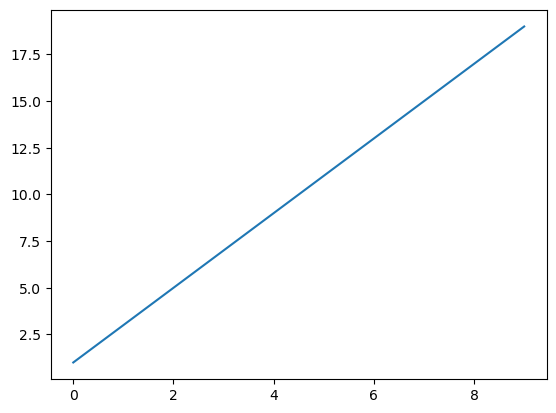

In [4]:
# | fig-cap: This is my lovely line plot
# | fig-alt: A line plot extending up and to the right
#| echo: false
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(10)
y = 2 * x + 1
plt.plot(x, y);

This is extra ~font~

## Data preparation

In [56]:
#| echo: false
from httpx import get as hget
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.set_printoptions(linewidth=150)

In [57]:
#| echo: false
batch_size = 64 # 32 how many independent sequences will be processed in parallel
block_size = 256 # 8 maximum context length for predictions
max_iters = 5_000
eval_interval = 500
lr = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_heads = 6 # 384 // 6 ---> every head is 64 dimensional
n_layer = 6
dropout = 0.2
# ---------
torch.manual_seed(1337);

This is a simple introduction to Transformers architecture following Andrej Karpathy excellent video series on [makemore](www.youtube.com). The post will follow lectuire 

Here we download sample dataset of Tiny Shakespeare dataset, which is a collection of all Shakespeare texts. The size is approximately 1 mln characters

In [53]:
f = hget("https://raw.githubusercontent.com/karpathy/ng-video-lecture/refs/heads/master/input.txt")
text = f.text

In [54]:
#| echo: false
from IPython.display import display, HTML
print("length of dataset in characters: ", len(text))
html = f"<details><summary>Click to show output</summary><pre>{text[:300]}</pre></details>"
display(HTML(html))


length of dataset in characters:  1115394


In [52]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Unique characters in the dataset:", ''.join(chars))
print(f"{vocab_size=}")

Unique characters in the dataset: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab_size=65


Models work numbers, so let's create a mapping from characters to integers: encoder and decoder. Here we use a very simple encoder-decoder (tokenizer) by simply tokenizing each character by using their position. See tiktoken (used by OpenAI)

In [42]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch, i in stoi.items()}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string and output a list of integers
decode = lambda l: ''.join((itos[o] for o in l) )# decoder: take a list of integers and output a string
print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


Let's encode the whole text dataset and store it into a torch.Tensor data. Currently data is simply a tensor stretched in a row. We also split our data into training (90% of the data) and validation (10% of the data) sets to calculate accuracy of our model and avoid overfitting. Without testing the model on a hold-out validation set we risk our model just memorizing the whole training set and having no actual predictive / creative power.

In [61]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100]) # the 1000 characters we looked at earlier will look to GPT like this)

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44, 53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52,
        63,  1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1, 57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43,
        39, 49,  6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [62]:
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
print(len(train_data))
print(len(val_data))

1003854
111540


We will pass data (Shakespeare texts) into transformer model using batches because feeding the whole text at once will be computationally prohibitive. The idea is to pass random blocks (sequence) of text into a model and train it on predicting the next character. We can illustrate it below. In each sequence we train transformer model on context size from 1 to block_size. This allows the model to see different contexts in predicting the next character in a sequence. In generating text the model starts with a context on 1 and then it will predict up to a block_size characters and then just truncate because it is limited by the context of block_size.

In [63]:
block_sz = 8 # context length
x = train_data[:block_sz]
y = train_data[1:block_sz+1]
for t in  range(block_sz):
    context = x[:t+1]
    target = y[t]
    print(f"When input is {context} the target : {target}")

When input is tensor([18]) the target : 47
When input is tensor([18, 47]) the target : 56
When input is tensor([18, 47, 56]) the target : 57
When input is tensor([18, 47, 56, 57]) the target : 58
When input is tensor([18, 47, 56, 57, 58]) the target : 1
When input is tensor([18, 47, 56, 57, 58,  1]) the target : 15
When input is tensor([18, 47, 56, 57, 58,  1, 15]) the target : 47
When input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target : 58


We want to utilize GPU's power of parallel calculations and feed multiple sequences in a batch.

In [73]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == "train" else val_data
    ix = torch.randint(0, len(data)-block_size, (batch_size,)) # random offsets
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x,y = x.to(device), y.to(device)
    return x, y

In [74]:
torch.manual_seed(1337)
batch_size = 4 # number of independent sequences we process in parallel
block_size = 8 # maximum context length for predictions
xb, yb = get_batch('train')

print('inputs:')
print(xb.shape)
print(xb,'\n')
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]], device='cuda:0') 

targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]], device='cuda:0')


In [76]:
# echo:false
output = ""
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b,:t+1]
        target = yb[b,t]
        output += f"When input is {context.tolist()} the target : {target}\n"
html = f"<details><summary>Click to show output</summary><pre>{output}</pre></details>"
display(HTML(html))

So each batch of 4 random sequences yields 32 examples (4 * 8) that will be fed into a neural net.

In [77]:
print(xb)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]], device='cuda:0')


Let's create a function to estimate average loss across a number of batches `eval_iters`. That allows us to have a more smooth curve.

In [78]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Baseline model Bigram model

Let's implement the simplest language model - Bigram Language Model. Each token is embedded in a vocab_size vector, so our batch of size (B,T) becomes (B,T,C), where C stands for channels and is vocab_size in our example. Those channels are treated as logits (scored) in predicting the next character based on the individual identity of the current token, because there is no interaction between current token and previous ones. Tokesn don't talk to each other and there is no context.

## Mathematical Trick in Self-Attention

We want our tokens to have a way of communicating with each other. The simplest way to achieve that, it to average channels corresponding to the previous tokens. Note that we want each token to be able to communicate only with the past, not the future.